## Интерпретация моделей и калибровка вероятностей

Будем тренироваться на примере задачи классификации оттоковых клиентов

In [ ]:
!pip install eli5 -q
!pip install lime -q
!pip install shap -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.3 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import eli5, lime, shap

from catboost import CatBoostClassifier

Загрузим данные

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/churn_clients.csv")

data.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,KS,128,415,No,Yes,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,False


Обработайте признаки:

* удалите категориальные признаки с больше, чем двумя различными значениями (обратите внимание, что `areacode` - также категориальный признак)

* бинарные признаки перведите в числа: True/Yes -> 1, False/No -> 0

In [7]:
catt_cols = data.select_dtypes(include=object).columns.tolist()

catt_cols.append('areacode')


array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

## Вопрос

Сколько колонок осталось в таблице data?

In [8]:
real_cat_cols = [col for col in catt_cols if len(data[col].unique()) > 2]

In [10]:
data = data.drop(real_cat_cols, axis=1)

In [13]:
binary = [col for col in data.columns.tolist() if len(data[col].unique()) ==2]

In [18]:
data[binary] = data[binary].replace({True : 1, False : 0, 'Yes' : 1, 'No' : 0})
data

,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,128,0,1,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,0
1,107,0,1,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,0
2,137,0,0,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,0
3,84,1,0,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,0
4,75,1,0,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77.0,26.55,215.5,126.0,18.32,279.1,83.0,12.56,9.9,6.0,2.67,2,0
3329,68,0,0,0,231.1,57.0,39.29,153.4,55.0,13.04,191.3,123.0,8.61,9.6,4.0,2.59,3,0
3330,28,0,0,0,180.8,109.0,30.74,288.8,58.0,24.55,191.9,91.0,8.64,14.1,6.0,3.81,2,0
3331,184,1,0,0,213.8,105.0,36.35,159.6,84.0,13.57,139.2,137.0,6.26,5.0,10.0,1.35,2,0


In [19]:
X = data.drop('churn', axis=1)
y = data['churn']

Разбейте данные на тренировочную и тестовую части. Размер тестовой части - 25%, `random_state=42`.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape[0]

2499

## Вопрос

Сколько строк в тренировочных данных?

In [21]:
X_train.shape[0]

2499

Обучите CatBoostClassifier с гиперпараметрами по умолчанию и `random_state=42` на тренировочных данных, сделайте прогноз на тестовых данных и вычислите значение ROC-AUC.

In [24]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

model = CatBoostClassifier(random_state=42)
model.fit(X_train, y_train)

predict = model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, predict)

Learning rate set to 0.015233
0:	learn: 0.6752635	total: 3.37ms	remaining: 3.36s
1:	learn: 0.6617820	total: 5.76ms	remaining: 2.87s
2:	learn: 0.6479005	total: 8.01ms	remaining: 2.66s
3:	learn: 0.6338435	total: 9.38ms	remaining: 2.33s
4:	learn: 0.6204428	total: 10.8ms	remaining: 2.15s
5:	learn: 0.6097648	total: 12ms	remaining: 1.98s
6:	learn: 0.5982691	total: 13.4ms	remaining: 1.9s
7:	learn: 0.5866627	total: 14.8ms	remaining: 1.83s
8:	learn: 0.5751202	total: 16.3ms	remaining: 1.79s
9:	learn: 0.5632503	total: 17.7ms	remaining: 1.76s
10:	learn: 0.5487198	total: 19.3ms	remaining: 1.74s
11:	learn: 0.5359360	total: 20.6ms	remaining: 1.7s
12:	learn: 0.5268862	total: 21.9ms	remaining: 1.67s
13:	learn: 0.5157269	total: 23.4ms	remaining: 1.65s
14:	learn: 0.5063566	total: 24.8ms	remaining: 1.63s
15:	learn: 0.4959042	total: 26.2ms	remaining: 1.61s
16:	learn: 0.4871783	total: 27.5ms	remaining: 1.59s
17:	learn: 0.4764523	total: 28.9ms	remaining: 1.58s
18:	learn: 0.4692380	total: 30.3ms	remaining: 1.

252:	learn: 0.1452491	total: 376ms	remaining: 1.11s
253:	learn: 0.1451715	total: 378ms	remaining: 1.11s
254:	learn: 0.1449107	total: 379ms	remaining: 1.11s
255:	learn: 0.1447190	total: 381ms	remaining: 1.11s
256:	learn: 0.1445234	total: 382ms	remaining: 1.1s
257:	learn: 0.1443350	total: 384ms	remaining: 1.1s
258:	learn: 0.1440791	total: 385ms	remaining: 1.1s
259:	learn: 0.1438579	total: 387ms	remaining: 1.1s
260:	learn: 0.1435613	total: 388ms	remaining: 1.1s
261:	learn: 0.1433841	total: 389ms	remaining: 1.1s
262:	learn: 0.1432160	total: 391ms	remaining: 1.09s
263:	learn: 0.1429593	total: 392ms	remaining: 1.09s
264:	learn: 0.1428094	total: 394ms	remaining: 1.09s
265:	learn: 0.1425352	total: 395ms	remaining: 1.09s
266:	learn: 0.1423634	total: 397ms	remaining: 1.09s
267:	learn: 0.1420403	total: 398ms	remaining: 1.09s
268:	learn: 0.1418202	total: 400ms	remaining: 1.09s
269:	learn: 0.1414985	total: 401ms	remaining: 1.08s
270:	learn: 0.1414166	total: 403ms	remaining: 1.08s
271:	learn: 0.1413

501:	learn: 0.1103170	total: 751ms	remaining: 745ms
502:	learn: 0.1102909	total: 753ms	remaining: 744ms
503:	learn: 0.1101922	total: 755ms	remaining: 743ms
504:	learn: 0.1100325	total: 757ms	remaining: 742ms
505:	learn: 0.1098836	total: 759ms	remaining: 741ms
506:	learn: 0.1097596	total: 760ms	remaining: 739ms
507:	learn: 0.1097109	total: 762ms	remaining: 738ms
508:	learn: 0.1096648	total: 764ms	remaining: 737ms
509:	learn: 0.1096453	total: 766ms	remaining: 736ms
510:	learn: 0.1096008	total: 767ms	remaining: 734ms
511:	learn: 0.1094585	total: 769ms	remaining: 733ms
512:	learn: 0.1093402	total: 771ms	remaining: 732ms
513:	learn: 0.1092688	total: 773ms	remaining: 731ms
514:	learn: 0.1091228	total: 775ms	remaining: 730ms
515:	learn: 0.1089538	total: 777ms	remaining: 729ms
516:	learn: 0.1088294	total: 780ms	remaining: 728ms
517:	learn: 0.1088003	total: 783ms	remaining: 729ms
518:	learn: 0.1087409	total: 786ms	remaining: 728ms
519:	learn: 0.1086130	total: 788ms	remaining: 727ms
520:	learn: 

733:	learn: 0.0892285	total: 1.13s	remaining: 409ms
734:	learn: 0.0891585	total: 1.13s	remaining: 408ms
735:	learn: 0.0891132	total: 1.13s	remaining: 406ms
736:	learn: 0.0889495	total: 1.13s	remaining: 405ms
737:	learn: 0.0888037	total: 1.14s	remaining: 403ms
738:	learn: 0.0887745	total: 1.14s	remaining: 402ms
739:	learn: 0.0887646	total: 1.14s	remaining: 400ms
740:	learn: 0.0886859	total: 1.14s	remaining: 399ms
741:	learn: 0.0886212	total: 1.14s	remaining: 397ms
742:	learn: 0.0884974	total: 1.14s	remaining: 396ms
743:	learn: 0.0884408	total: 1.15s	remaining: 394ms
744:	learn: 0.0884044	total: 1.15s	remaining: 393ms
745:	learn: 0.0883676	total: 1.15s	remaining: 391ms
746:	learn: 0.0882461	total: 1.15s	remaining: 390ms
747:	learn: 0.0882238	total: 1.15s	remaining: 388ms
748:	learn: 0.0881461	total: 1.15s	remaining: 386ms
749:	learn: 0.0880872	total: 1.16s	remaining: 385ms
750:	learn: 0.0879510	total: 1.16s	remaining: 383ms
751:	learn: 0.0878724	total: 1.16s	remaining: 382ms
752:	learn: 

980:	learn: 0.0712839	total: 1.5s	remaining: 29.2ms
981:	learn: 0.0712211	total: 1.51s	remaining: 27.6ms
982:	learn: 0.0711286	total: 1.51s	remaining: 26.1ms
983:	learn: 0.0710805	total: 1.51s	remaining: 24.6ms
984:	learn: 0.0709954	total: 1.51s	remaining: 23ms
985:	learn: 0.0709207	total: 1.51s	remaining: 21.5ms
986:	learn: 0.0708481	total: 1.51s	remaining: 20ms
987:	learn: 0.0707389	total: 1.52s	remaining: 18.4ms
988:	learn: 0.0706439	total: 1.52s	remaining: 16.9ms
989:	learn: 0.0705462	total: 1.52s	remaining: 15.4ms
990:	learn: 0.0705370	total: 1.52s	remaining: 13.8ms
991:	learn: 0.0704730	total: 1.52s	remaining: 12.3ms
992:	learn: 0.0703822	total: 1.52s	remaining: 10.7ms
993:	learn: 0.0703272	total: 1.52s	remaining: 9.21ms
994:	learn: 0.0702292	total: 1.53s	remaining: 7.67ms
995:	learn: 0.0701634	total: 1.53s	remaining: 6.14ms
996:	learn: 0.0700748	total: 1.53s	remaining: 4.6ms
997:	learn: 0.0700463	total: 1.53s	remaining: 3.07ms
998:	learn: 0.0699754	total: 1.53s	remaining: 1.53ms

In [25]:
roc_auc

0.9355035260930887

## Вопрос

Чему равно значение ROC-AUC на тестовых данных? Ответ округлите до сотых.

In [ ]:
from sklearn.metrics import roc_auc_score

# your code here

Выведите на экран гистограмму важности признаков (стандартную, посчитанную на основе Information Gain)

<AxesSubplot:xlabel='importance', ylabel='feature'>

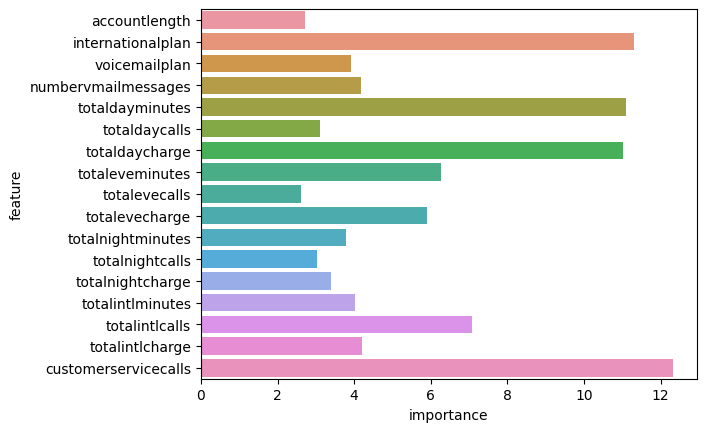

In [26]:
f_i = pd.DataFrame({'feature' : X_train.columns.tolist(), 'importance' : model.feature_importances_})
sns.barplot(data=f_i, x='importance', y='feature')

## Вопрос

Какой признак наиболее важен с точки зрения этого подхода?

Постройте гистограмму permutation importance по тренировочным данным

In [29]:
perms = eli5.sklearn.PermutationImportance(model, random_state=42).fit(X_train, y_train)

eli5.show_weights(perms, feature_names=X_train.columns.tolist())

Weight,Feature
0.0599 ± 0.0047,customerservicecalls
0.0545 ± 0.0053,totaldaycharge
0.0519 ± 0.0045,internationalplan
0.0502 ± 0.0065,totaldayminutes
0.0241 ± 0.0031,totalintlcalls
0.0211 ± 0.0012,totaleveminutes
0.0189 ± 0.0014,totalevecharge
0.0142 ± 0.0026,numbervmailmessages
0.0138 ± 0.0032,voicemailplan
0.0130 ± 0.0015,totalintlcharge


## Вопрос

Сколько признаков выделяет метод как наиболее важные? (темно-зеленый цвет на визуализации)

Постройте гистограмму shap values по тестовым данным

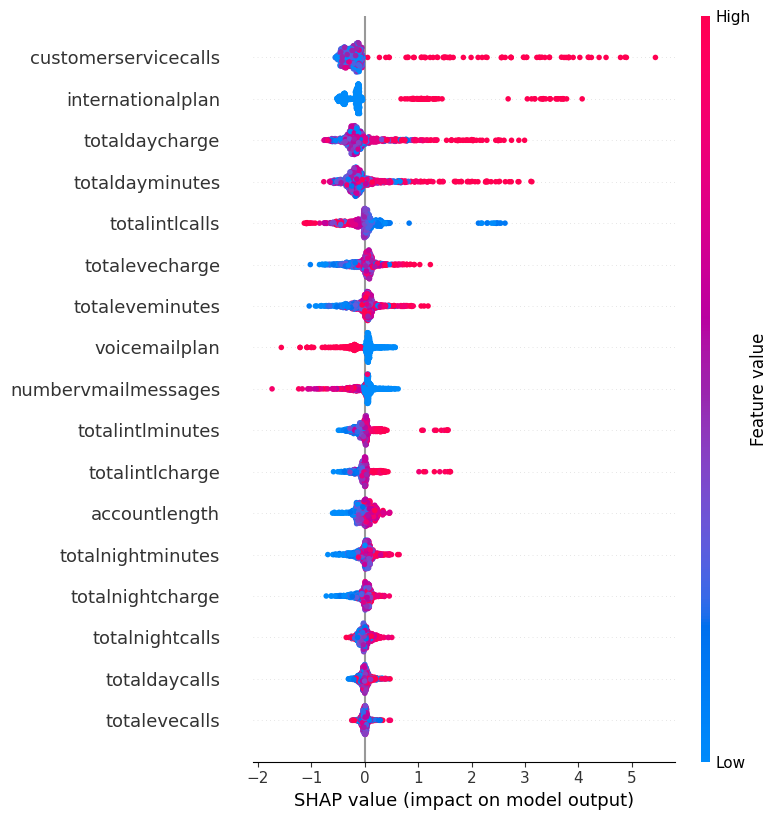

In [32]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

## Вопрос

Какой признак наименее важен с точки зрения подхода SHAP?

Проинтерпретируем теперь индивидуальные прогнозы моделей

Проинтерпретируйте прогноз на тестовом объекте с индексом 5 методами:

* SHAP
* LIME

In [33]:
shap.initjs()
print(f'Ответ : {y_test.iloc[5]}')

shap.force_plot(explainer.expected_value, shap_values[5:], X_test.iloc[5:]) 

Ответ : 0


## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения SHAP?

In [34]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=X_test.columns.values.tolist(), mode='regression')
explanation = explainer.explain_instance(X_test.values[5], model.predict, num_features=5)

explanation.show_in_notebook(show_table=True)

## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения метода LIME?

## Калибровка вероятностей

Сделайте калибровку вероятностей с помощью методов 'sigmoid' и 'isotonic' при помощи CalibratedClassifierCV с `cv=2`.

Нарисуйте на одном графике исходную калибровочную кривую для CatBoost и две кривые после калибровки.

In [35]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.metrics import brier_score_loss

Learning rate set to 0.015233
0:	learn: 0.6752635	total: 3.31ms	remaining: 3.3s
1:	learn: 0.6617820	total: 5.98ms	remaining: 2.98s
2:	learn: 0.6479005	total: 8.55ms	remaining: 2.84s
3:	learn: 0.6338435	total: 11ms	remaining: 2.75s
4:	learn: 0.6204428	total: 14.5ms	remaining: 2.89s
5:	learn: 0.6097648	total: 17.3ms	remaining: 2.86s
6:	learn: 0.5982691	total: 20.7ms	remaining: 2.93s
7:	learn: 0.5866627	total: 24.2ms	remaining: 3s
8:	learn: 0.5751202	total: 26.9ms	remaining: 2.97s
9:	learn: 0.5632503	total: 29.4ms	remaining: 2.91s
10:	learn: 0.5487198	total: 31.8ms	remaining: 2.86s
11:	learn: 0.5359360	total: 33.7ms	remaining: 2.78s
12:	learn: 0.5268862	total: 35.2ms	remaining: 2.67s
13:	learn: 0.5157269	total: 36.6ms	remaining: 2.58s
14:	learn: 0.5063566	total: 38.2ms	remaining: 2.51s
15:	learn: 0.4959042	total: 39.6ms	remaining: 2.44s
16:	learn: 0.4871783	total: 41.1ms	remaining: 2.38s
17:	learn: 0.4764523	total: 42.7ms	remaining: 2.33s
18:	learn: 0.4692380	total: 44.1ms	remaining: 2.28

231:	learn: 0.1499244	total: 375ms	remaining: 1.24s
232:	learn: 0.1497325	total: 378ms	remaining: 1.24s
233:	learn: 0.1494726	total: 380ms	remaining: 1.24s
234:	learn: 0.1492235	total: 381ms	remaining: 1.24s
235:	learn: 0.1490184	total: 383ms	remaining: 1.24s
236:	learn: 0.1487973	total: 384ms	remaining: 1.24s
237:	learn: 0.1485909	total: 386ms	remaining: 1.24s
238:	learn: 0.1484387	total: 388ms	remaining: 1.23s
239:	learn: 0.1481670	total: 389ms	remaining: 1.23s
240:	learn: 0.1480015	total: 391ms	remaining: 1.23s
241:	learn: 0.1477720	total: 392ms	remaining: 1.23s
242:	learn: 0.1475682	total: 394ms	remaining: 1.23s
243:	learn: 0.1473575	total: 396ms	remaining: 1.23s
244:	learn: 0.1471564	total: 397ms	remaining: 1.22s
245:	learn: 0.1468232	total: 399ms	remaining: 1.22s
246:	learn: 0.1466327	total: 400ms	remaining: 1.22s
247:	learn: 0.1465267	total: 402ms	remaining: 1.22s
248:	learn: 0.1463513	total: 404ms	remaining: 1.22s
249:	learn: 0.1461187	total: 406ms	remaining: 1.22s
250:	learn: 

470:	learn: 0.1136851	total: 752ms	remaining: 844ms
471:	learn: 0.1135022	total: 754ms	remaining: 843ms
472:	learn: 0.1134123	total: 755ms	remaining: 842ms
473:	learn: 0.1132779	total: 757ms	remaining: 840ms
474:	learn: 0.1131735	total: 759ms	remaining: 839ms
475:	learn: 0.1130327	total: 760ms	remaining: 837ms
476:	learn: 0.1130305	total: 761ms	remaining: 835ms
477:	learn: 0.1129482	total: 763ms	remaining: 833ms
478:	learn: 0.1128524	total: 764ms	remaining: 831ms
479:	learn: 0.1127543	total: 766ms	remaining: 830ms
480:	learn: 0.1126902	total: 768ms	remaining: 828ms
481:	learn: 0.1126024	total: 769ms	remaining: 827ms
482:	learn: 0.1123934	total: 772ms	remaining: 826ms
483:	learn: 0.1123647	total: 775ms	remaining: 827ms
484:	learn: 0.1123255	total: 777ms	remaining: 825ms
485:	learn: 0.1121859	total: 779ms	remaining: 823ms
486:	learn: 0.1121043	total: 780ms	remaining: 822ms
487:	learn: 0.1120378	total: 781ms	remaining: 820ms
488:	learn: 0.1119279	total: 783ms	remaining: 818ms
489:	learn: 

694:	learn: 0.0926027	total: 1.13s	remaining: 494ms
695:	learn: 0.0925079	total: 1.13s	remaining: 493ms
696:	learn: 0.0924153	total: 1.13s	remaining: 491ms
697:	learn: 0.0922597	total: 1.13s	remaining: 490ms
698:	learn: 0.0921046	total: 1.13s	remaining: 488ms
699:	learn: 0.0920817	total: 1.14s	remaining: 487ms
700:	learn: 0.0920087	total: 1.14s	remaining: 485ms
701:	learn: 0.0919530	total: 1.14s	remaining: 483ms
702:	learn: 0.0918873	total: 1.14s	remaining: 482ms
703:	learn: 0.0917209	total: 1.14s	remaining: 480ms
704:	learn: 0.0916388	total: 1.14s	remaining: 478ms
705:	learn: 0.0915328	total: 1.14s	remaining: 477ms
706:	learn: 0.0913674	total: 1.15s	remaining: 475ms
707:	learn: 0.0912958	total: 1.15s	remaining: 474ms
708:	learn: 0.0911958	total: 1.15s	remaining: 472ms
709:	learn: 0.0911120	total: 1.15s	remaining: 471ms
710:	learn: 0.0910276	total: 1.15s	remaining: 469ms
711:	learn: 0.0909806	total: 1.16s	remaining: 467ms
712:	learn: 0.0907961	total: 1.16s	remaining: 466ms
713:	learn: 

927:	learn: 0.0750979	total: 1.5s	remaining: 117ms
928:	learn: 0.0750140	total: 1.5s	remaining: 115ms
929:	learn: 0.0749301	total: 1.5s	remaining: 113ms
930:	learn: 0.0748289	total: 1.51s	remaining: 112ms
931:	learn: 0.0747393	total: 1.51s	remaining: 110ms
932:	learn: 0.0746495	total: 1.51s	remaining: 108ms
933:	learn: 0.0745201	total: 1.51s	remaining: 107ms
934:	learn: 0.0744147	total: 1.51s	remaining: 105ms
935:	learn: 0.0743577	total: 1.51s	remaining: 104ms
936:	learn: 0.0743346	total: 1.52s	remaining: 102ms
937:	learn: 0.0742538	total: 1.52s	remaining: 100ms
938:	learn: 0.0741331	total: 1.52s	remaining: 98.7ms
939:	learn: 0.0740456	total: 1.52s	remaining: 97.1ms
940:	learn: 0.0740224	total: 1.52s	remaining: 95.5ms
941:	learn: 0.0738726	total: 1.52s	remaining: 93.9ms
942:	learn: 0.0737918	total: 1.53s	remaining: 92.3ms
943:	learn: 0.0737196	total: 1.53s	remaining: 90.7ms
944:	learn: 0.0736609	total: 1.53s	remaining: 89.1ms
945:	learn: 0.0736359	total: 1.53s	remaining: 87.5ms
946:	le

131:	learn: 0.2303320	total: 185ms	remaining: 1.22s
132:	learn: 0.2294799	total: 187ms	remaining: 1.22s
133:	learn: 0.2284468	total: 189ms	remaining: 1.22s
134:	learn: 0.2272708	total: 190ms	remaining: 1.22s
135:	learn: 0.2265016	total: 191ms	remaining: 1.21s
136:	learn: 0.2255355	total: 192ms	remaining: 1.21s
137:	learn: 0.2249540	total: 193ms	remaining: 1.21s
138:	learn: 0.2240495	total: 195ms	remaining: 1.21s
139:	learn: 0.2230041	total: 196ms	remaining: 1.21s
140:	learn: 0.2224190	total: 198ms	remaining: 1.21s
141:	learn: 0.2216113	total: 199ms	remaining: 1.21s
142:	learn: 0.2207570	total: 201ms	remaining: 1.2s
143:	learn: 0.2202487	total: 202ms	remaining: 1.2s
144:	learn: 0.2190942	total: 204ms	remaining: 1.2s
145:	learn: 0.2184786	total: 205ms	remaining: 1.2s
146:	learn: 0.2177270	total: 206ms	remaining: 1.2s
147:	learn: 0.2172282	total: 207ms	remaining: 1.19s
148:	learn: 0.2164270	total: 209ms	remaining: 1.19s
149:	learn: 0.2157358	total: 210ms	remaining: 1.19s
150:	learn: 0.215

410:	learn: 0.1304396	total: 556ms	remaining: 797ms
411:	learn: 0.1303111	total: 558ms	remaining: 796ms
412:	learn: 0.1301193	total: 559ms	remaining: 795ms
413:	learn: 0.1298776	total: 561ms	remaining: 794ms
414:	learn: 0.1297081	total: 562ms	remaining: 792ms
415:	learn: 0.1295264	total: 563ms	remaining: 791ms
416:	learn: 0.1293814	total: 565ms	remaining: 789ms
417:	learn: 0.1291805	total: 566ms	remaining: 788ms
418:	learn: 0.1290379	total: 568ms	remaining: 787ms
419:	learn: 0.1289053	total: 569ms	remaining: 786ms
420:	learn: 0.1287204	total: 570ms	remaining: 784ms
421:	learn: 0.1286719	total: 572ms	remaining: 783ms
422:	learn: 0.1283402	total: 573ms	remaining: 782ms
423:	learn: 0.1282374	total: 574ms	remaining: 780ms
424:	learn: 0.1279905	total: 576ms	remaining: 780ms
425:	learn: 0.1276948	total: 578ms	remaining: 778ms
426:	learn: 0.1275199	total: 579ms	remaining: 778ms
427:	learn: 0.1273542	total: 581ms	remaining: 776ms
428:	learn: 0.1271460	total: 582ms	remaining: 774ms
429:	learn: 

674:	learn: 0.0924601	total: 926ms	remaining: 446ms
675:	learn: 0.0923329	total: 928ms	remaining: 445ms
676:	learn: 0.0922090	total: 930ms	remaining: 444ms
677:	learn: 0.0920391	total: 931ms	remaining: 442ms
678:	learn: 0.0918496	total: 932ms	remaining: 441ms
679:	learn: 0.0917317	total: 934ms	remaining: 439ms
680:	learn: 0.0916997	total: 935ms	remaining: 438ms
681:	learn: 0.0915644	total: 937ms	remaining: 437ms
682:	learn: 0.0914910	total: 938ms	remaining: 436ms
683:	learn: 0.0914280	total: 940ms	remaining: 434ms
684:	learn: 0.0913658	total: 942ms	remaining: 433ms
685:	learn: 0.0913314	total: 943ms	remaining: 432ms
686:	learn: 0.0912450	total: 944ms	remaining: 430ms
687:	learn: 0.0911705	total: 946ms	remaining: 429ms
688:	learn: 0.0910144	total: 948ms	remaining: 428ms
689:	learn: 0.0910003	total: 949ms	remaining: 426ms
690:	learn: 0.0908210	total: 951ms	remaining: 425ms
691:	learn: 0.0907800	total: 952ms	remaining: 424ms
692:	learn: 0.0906584	total: 953ms	remaining: 422ms
693:	learn: 

943:	learn: 0.0676827	total: 1.3s	remaining: 76.9ms
944:	learn: 0.0676050	total: 1.3s	remaining: 75.6ms
945:	learn: 0.0675343	total: 1.3s	remaining: 74.2ms
946:	learn: 0.0674574	total: 1.3s	remaining: 72.9ms
947:	learn: 0.0673671	total: 1.3s	remaining: 71.5ms
948:	learn: 0.0673043	total: 1.3s	remaining: 70.1ms
949:	learn: 0.0671666	total: 1.3s	remaining: 68.7ms
950:	learn: 0.0670278	total: 1.31s	remaining: 67.3ms
951:	learn: 0.0669931	total: 1.31s	remaining: 66ms
952:	learn: 0.0669304	total: 1.31s	remaining: 64.6ms
953:	learn: 0.0668426	total: 1.31s	remaining: 63.2ms
954:	learn: 0.0667653	total: 1.31s	remaining: 61.8ms
955:	learn: 0.0667184	total: 1.31s	remaining: 60.5ms
956:	learn: 0.0665958	total: 1.31s	remaining: 59.1ms
957:	learn: 0.0664778	total: 1.32s	remaining: 57.7ms
958:	learn: 0.0663637	total: 1.32s	remaining: 56.3ms
959:	learn: 0.0662364	total: 1.32s	remaining: 55ms
960:	learn: 0.0661205	total: 1.32s	remaining: 53.6ms
961:	learn: 0.0659706	total: 1.32s	remaining: 52.2ms
962:

139:	learn: 0.2097469	total: 185ms	remaining: 1.14s
140:	learn: 0.2090204	total: 187ms	remaining: 1.14s
141:	learn: 0.2082440	total: 188ms	remaining: 1.14s
142:	learn: 0.2075469	total: 190ms	remaining: 1.14s
143:	learn: 0.2066870	total: 191ms	remaining: 1.13s
144:	learn: 0.2059474	total: 192ms	remaining: 1.13s
145:	learn: 0.2053294	total: 193ms	remaining: 1.13s
146:	learn: 0.2045693	total: 195ms	remaining: 1.13s
147:	learn: 0.2038445	total: 196ms	remaining: 1.13s
148:	learn: 0.2031101	total: 197ms	remaining: 1.13s
149:	learn: 0.2024534	total: 199ms	remaining: 1.13s
150:	learn: 0.2015589	total: 200ms	remaining: 1.13s
151:	learn: 0.2008632	total: 202ms	remaining: 1.13s
152:	learn: 0.2003518	total: 203ms	remaining: 1.13s
153:	learn: 0.1995005	total: 205ms	remaining: 1.12s
154:	learn: 0.1988206	total: 206ms	remaining: 1.12s
155:	learn: 0.1980720	total: 208ms	remaining: 1.12s
156:	learn: 0.1973564	total: 209ms	remaining: 1.12s
157:	learn: 0.1966346	total: 211ms	remaining: 1.12s
158:	learn: 

425:	learn: 0.1139095	total: 554ms	remaining: 747ms
426:	learn: 0.1136540	total: 556ms	remaining: 746ms
427:	learn: 0.1134516	total: 558ms	remaining: 745ms
428:	learn: 0.1131689	total: 559ms	remaining: 744ms
429:	learn: 0.1129311	total: 560ms	remaining: 743ms
430:	learn: 0.1127924	total: 562ms	remaining: 742ms
431:	learn: 0.1125757	total: 563ms	remaining: 741ms
432:	learn: 0.1124469	total: 565ms	remaining: 739ms
433:	learn: 0.1123142	total: 566ms	remaining: 738ms
434:	learn: 0.1121010	total: 567ms	remaining: 737ms
435:	learn: 0.1119432	total: 568ms	remaining: 735ms
436:	learn: 0.1117252	total: 570ms	remaining: 734ms
437:	learn: 0.1116152	total: 571ms	remaining: 732ms
438:	learn: 0.1114956	total: 572ms	remaining: 731ms
439:	learn: 0.1113463	total: 573ms	remaining: 730ms
440:	learn: 0.1111051	total: 574ms	remaining: 728ms
441:	learn: 0.1109525	total: 576ms	remaining: 727ms
442:	learn: 0.1108421	total: 577ms	remaining: 726ms
443:	learn: 0.1107805	total: 579ms	remaining: 725ms
444:	learn: 

702:	learn: 0.0810629	total: 926ms	remaining: 391ms
703:	learn: 0.0808959	total: 927ms	remaining: 390ms
704:	learn: 0.0807932	total: 929ms	remaining: 389ms
705:	learn: 0.0806927	total: 930ms	remaining: 387ms
706:	learn: 0.0805658	total: 931ms	remaining: 386ms
707:	learn: 0.0805543	total: 932ms	remaining: 385ms
708:	learn: 0.0804094	total: 934ms	remaining: 383ms
709:	learn: 0.0802696	total: 935ms	remaining: 382ms
710:	learn: 0.0802008	total: 936ms	remaining: 381ms
711:	learn: 0.0801723	total: 938ms	remaining: 379ms
712:	learn: 0.0801032	total: 939ms	remaining: 378ms
713:	learn: 0.0800083	total: 940ms	remaining: 377ms
714:	learn: 0.0798315	total: 942ms	remaining: 375ms
715:	learn: 0.0797316	total: 943ms	remaining: 374ms
716:	learn: 0.0796671	total: 944ms	remaining: 373ms
717:	learn: 0.0795882	total: 946ms	remaining: 371ms
718:	learn: 0.0794465	total: 947ms	remaining: 370ms
719:	learn: 0.0793355	total: 949ms	remaining: 369ms
720:	learn: 0.0792900	total: 950ms	remaining: 368ms
721:	learn: 

988:	learn: 0.0595675	total: 1.3s	remaining: 14.4ms
989:	learn: 0.0595587	total: 1.3s	remaining: 13.1ms
990:	learn: 0.0595121	total: 1.3s	remaining: 11.8ms
991:	learn: 0.0594120	total: 1.3s	remaining: 10.5ms
992:	learn: 0.0593417	total: 1.3s	remaining: 9.19ms
993:	learn: 0.0592282	total: 1.3s	remaining: 7.88ms
994:	learn: 0.0592060	total: 1.31s	remaining: 6.57ms
995:	learn: 0.0591478	total: 1.31s	remaining: 5.25ms
996:	learn: 0.0590703	total: 1.31s	remaining: 3.94ms
997:	learn: 0.0590347	total: 1.31s	remaining: 2.63ms
998:	learn: 0.0590216	total: 1.31s	remaining: 1.31ms
999:	learn: 0.0590021	total: 1.31s	remaining: 0us
Learning rate set to 0.011328
0:	learn: 0.6798797	total: 1.33ms	remaining: 1.33s
1:	learn: 0.6709784	total: 2.71ms	remaining: 1.35s
2:	learn: 0.6604645	total: 4.26ms	remaining: 1.42s
3:	learn: 0.6490571	total: 5.78ms	remaining: 1.44s
4:	learn: 0.6389932	total: 7.25ms	remaining: 1.44s
5:	learn: 0.6306545	total: 8.32ms	remaining: 1.38s
6:	learn: 0.6215182	total: 9.62ms	rem

283:	learn: 0.1579538	total: 381ms	remaining: 960ms
284:	learn: 0.1576895	total: 383ms	remaining: 960ms
285:	learn: 0.1573888	total: 384ms	remaining: 960ms
286:	learn: 0.1570915	total: 386ms	remaining: 958ms
287:	learn: 0.1569911	total: 387ms	remaining: 956ms
288:	learn: 0.1566803	total: 388ms	remaining: 954ms
289:	learn: 0.1564135	total: 389ms	remaining: 953ms
290:	learn: 0.1560883	total: 390ms	remaining: 951ms
291:	learn: 0.1557711	total: 392ms	remaining: 949ms
292:	learn: 0.1555231	total: 393ms	remaining: 948ms
293:	learn: 0.1552902	total: 394ms	remaining: 946ms
294:	learn: 0.1549922	total: 395ms	remaining: 945ms
295:	learn: 0.1546993	total: 397ms	remaining: 944ms
296:	learn: 0.1543114	total: 398ms	remaining: 942ms
297:	learn: 0.1540184	total: 399ms	remaining: 941ms
298:	learn: 0.1537811	total: 401ms	remaining: 939ms
299:	learn: 0.1536002	total: 402ms	remaining: 938ms
300:	learn: 0.1533471	total: 403ms	remaining: 936ms
301:	learn: 0.1529977	total: 404ms	remaining: 935ms
302:	learn: 

583:	learn: 0.1037498	total: 752ms	remaining: 536ms
584:	learn: 0.1035942	total: 754ms	remaining: 535ms
585:	learn: 0.1034998	total: 755ms	remaining: 533ms
586:	learn: 0.1033562	total: 756ms	remaining: 532ms
587:	learn: 0.1031945	total: 757ms	remaining: 531ms
588:	learn: 0.1031676	total: 758ms	remaining: 529ms
589:	learn: 0.1030317	total: 759ms	remaining: 528ms
590:	learn: 0.1028204	total: 761ms	remaining: 526ms
591:	learn: 0.1026303	total: 762ms	remaining: 525ms
592:	learn: 0.1024909	total: 763ms	remaining: 523ms
593:	learn: 0.1022934	total: 764ms	remaining: 522ms
594:	learn: 0.1021980	total: 765ms	remaining: 521ms
595:	learn: 0.1020953	total: 766ms	remaining: 519ms
596:	learn: 0.1019579	total: 768ms	remaining: 518ms
597:	learn: 0.1018256	total: 769ms	remaining: 517ms
598:	learn: 0.1016876	total: 770ms	remaining: 515ms
599:	learn: 0.1015140	total: 771ms	remaining: 514ms
600:	learn: 0.1013394	total: 772ms	remaining: 513ms
601:	learn: 0.1012094	total: 774ms	remaining: 512ms
602:	learn: 

884:	learn: 0.0722706	total: 1.13s	remaining: 146ms
885:	learn: 0.0722092	total: 1.13s	remaining: 145ms
886:	learn: 0.0721381	total: 1.13s	remaining: 144ms
887:	learn: 0.0720900	total: 1.13s	remaining: 142ms
888:	learn: 0.0719578	total: 1.13s	remaining: 141ms
889:	learn: 0.0718378	total: 1.13s	remaining: 140ms
890:	learn: 0.0717971	total: 1.13s	remaining: 139ms
891:	learn: 0.0717647	total: 1.13s	remaining: 137ms
892:	learn: 0.0717392	total: 1.14s	remaining: 136ms
893:	learn: 0.0716087	total: 1.14s	remaining: 135ms
894:	learn: 0.0714836	total: 1.14s	remaining: 134ms
895:	learn: 0.0714237	total: 1.14s	remaining: 132ms
896:	learn: 0.0712900	total: 1.14s	remaining: 131ms
897:	learn: 0.0712717	total: 1.14s	remaining: 130ms
898:	learn: 0.0712525	total: 1.14s	remaining: 129ms
899:	learn: 0.0711394	total: 1.15s	remaining: 127ms
900:	learn: 0.0710484	total: 1.15s	remaining: 126ms
901:	learn: 0.0710006	total: 1.15s	remaining: 125ms
902:	learn: 0.0709108	total: 1.15s	remaining: 123ms
903:	learn: 

137:	learn: 0.2119064	total: 185ms	remaining: 1.16s
138:	learn: 0.2108532	total: 187ms	remaining: 1.16s
139:	learn: 0.2097469	total: 188ms	remaining: 1.15s
140:	learn: 0.2090204	total: 189ms	remaining: 1.15s
141:	learn: 0.2082440	total: 191ms	remaining: 1.15s
142:	learn: 0.2075469	total: 192ms	remaining: 1.15s
143:	learn: 0.2066870	total: 193ms	remaining: 1.15s
144:	learn: 0.2059474	total: 195ms	remaining: 1.15s
145:	learn: 0.2053294	total: 196ms	remaining: 1.15s
146:	learn: 0.2045693	total: 197ms	remaining: 1.15s
147:	learn: 0.2038445	total: 199ms	remaining: 1.15s
148:	learn: 0.2031101	total: 201ms	remaining: 1.15s
149:	learn: 0.2024534	total: 202ms	remaining: 1.14s
150:	learn: 0.2015589	total: 203ms	remaining: 1.14s
151:	learn: 0.2008632	total: 205ms	remaining: 1.14s
152:	learn: 0.2003518	total: 206ms	remaining: 1.14s
153:	learn: 0.1995005	total: 207ms	remaining: 1.14s
154:	learn: 0.1988206	total: 209ms	remaining: 1.14s
155:	learn: 0.1980720	total: 211ms	remaining: 1.14s
156:	learn: 

395:	learn: 0.1188246	total: 552ms	remaining: 841ms
396:	learn: 0.1186670	total: 553ms	remaining: 840ms
397:	learn: 0.1184817	total: 556ms	remaining: 840ms
398:	learn: 0.1183372	total: 557ms	remaining: 839ms
399:	learn: 0.1182160	total: 558ms	remaining: 837ms
400:	learn: 0.1180589	total: 560ms	remaining: 836ms
401:	learn: 0.1178379	total: 562ms	remaining: 835ms
402:	learn: 0.1176378	total: 563ms	remaining: 834ms
403:	learn: 0.1175222	total: 564ms	remaining: 833ms
404:	learn: 0.1173432	total: 566ms	remaining: 831ms
405:	learn: 0.1172102	total: 567ms	remaining: 830ms
406:	learn: 0.1170758	total: 569ms	remaining: 829ms
407:	learn: 0.1169708	total: 570ms	remaining: 827ms
408:	learn: 0.1167354	total: 571ms	remaining: 826ms
409:	learn: 0.1165955	total: 573ms	remaining: 824ms
410:	learn: 0.1164987	total: 575ms	remaining: 824ms
411:	learn: 0.1163902	total: 576ms	remaining: 823ms
412:	learn: 0.1162443	total: 578ms	remaining: 821ms
413:	learn: 0.1160862	total: 579ms	remaining: 820ms
414:	learn: 

671:	learn: 0.0838537	total: 923ms	remaining: 450ms
672:	learn: 0.0836992	total: 925ms	remaining: 449ms
673:	learn: 0.0836065	total: 926ms	remaining: 448ms
674:	learn: 0.0834815	total: 929ms	remaining: 447ms
675:	learn: 0.0834574	total: 930ms	remaining: 446ms
676:	learn: 0.0833332	total: 931ms	remaining: 444ms
677:	learn: 0.0832589	total: 933ms	remaining: 443ms
678:	learn: 0.0832112	total: 934ms	remaining: 442ms
679:	learn: 0.0831178	total: 935ms	remaining: 440ms
680:	learn: 0.0830328	total: 936ms	remaining: 439ms
681:	learn: 0.0828715	total: 937ms	remaining: 437ms
682:	learn: 0.0828035	total: 939ms	remaining: 436ms
683:	learn: 0.0826585	total: 940ms	remaining: 434ms
684:	learn: 0.0826111	total: 942ms	remaining: 433ms
685:	learn: 0.0825850	total: 943ms	remaining: 432ms
686:	learn: 0.0824513	total: 944ms	remaining: 430ms
687:	learn: 0.0822618	total: 946ms	remaining: 429ms
688:	learn: 0.0821956	total: 947ms	remaining: 427ms
689:	learn: 0.0821229	total: 948ms	remaining: 426ms
690:	learn: 

863:	learn: 0.0685288	total: 1.3s	remaining: 205ms
864:	learn: 0.0684259	total: 1.3s	remaining: 203ms
865:	learn: 0.0683518	total: 1.3s	remaining: 202ms
866:	learn: 0.0682338	total: 1.3s	remaining: 200ms
867:	learn: 0.0681444	total: 1.31s	remaining: 199ms
868:	learn: 0.0681260	total: 1.31s	remaining: 197ms
869:	learn: 0.0680326	total: 1.31s	remaining: 196ms
870:	learn: 0.0679086	total: 1.31s	remaining: 194ms
871:	learn: 0.0678047	total: 1.31s	remaining: 193ms
872:	learn: 0.0677244	total: 1.31s	remaining: 191ms
873:	learn: 0.0675993	total: 1.31s	remaining: 190ms
874:	learn: 0.0675049	total: 1.32s	remaining: 188ms
875:	learn: 0.0674113	total: 1.32s	remaining: 187ms
876:	learn: 0.0673572	total: 1.32s	remaining: 185ms
877:	learn: 0.0672946	total: 1.32s	remaining: 184ms
878:	learn: 0.0672002	total: 1.32s	remaining: 182ms
879:	learn: 0.0671241	total: 1.32s	remaining: 180ms
880:	learn: 0.0671013	total: 1.32s	remaining: 179ms
881:	learn: 0.0670911	total: 1.33s	remaining: 178ms
882:	learn: 0.06

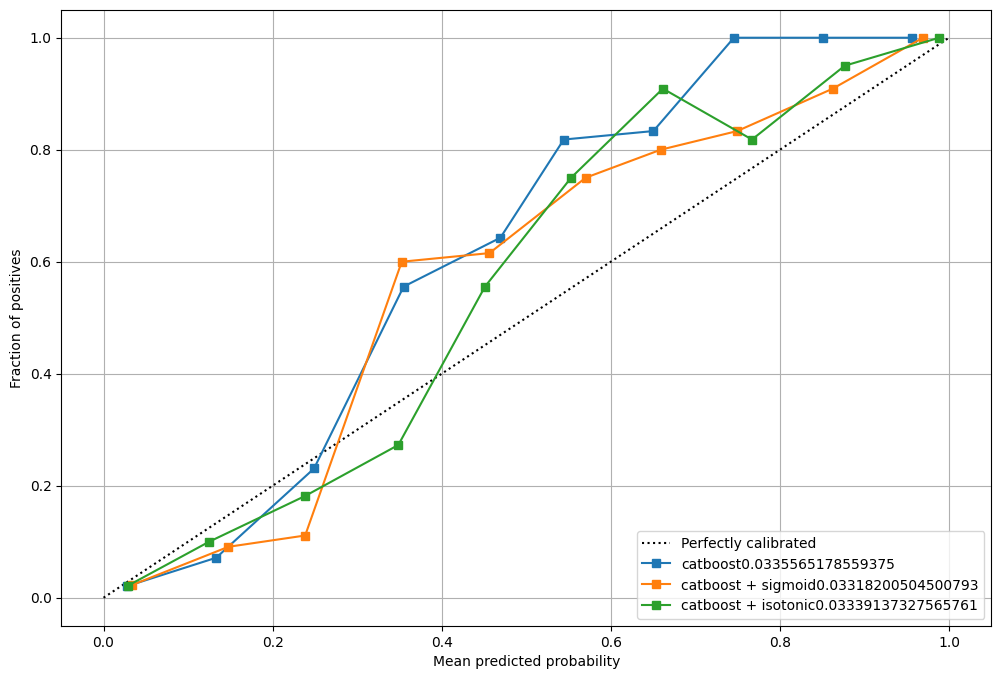

In [50]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.metrics import brier_score_loss
gnb = model
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method='sigmoid')

gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method='isotonic')

gnb_list = [
    (gnb, 'catboost'),
    ( gnb_sigmoid, 'catboost + sigmoid'),
    (gnb_isotonic, 'catboost + isotonic')
]

fig = plt.figure(figsize=(12,8))

gs = GridSpec(3,1)

ax_colibration_curve = fig.add_subplot(gs[:,0])

for estimator, name in (gnb_list):
    estimator.fit(X_train, y_train)
    br = brier_score_loss(y_test, estimator.predict_proba(X_test)[:,1])
    display = CalibrationDisplay.from_estimator(
        estimator,
        X_test,
        y_test,
        ax=ax_colibration_curve,
        n_bins=10,
        name= name + '' + str(br))
ax_colibration_curve.grid()
    


Вычислим `brier_score` до калибровки

In [ ]:
from sklearn.metrics import brier_score_loss

brier_score_loss(y_test, probs)

0.0335565178559375

In [51]:
np.round(0.03318200, 4)

0.0332

## Вопрос

Вычислите `brier_score` после обеих калибровок.

В ответ запишите наименьшее из двух полученных значений, округленное до десятитысячных.

In [ ]:
- 0.03318200
- 0.03391